# Project of AIF on Road Sign Recognition (AI Part)

#### Made by :
- Tomas Szabo 
- Gaspard Langlais 
- Herald Nkounkou 

### Check if cuda is avaible for GPU acceleartion

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use of :", device)

Use of : cuda


## Configuration

### Installation of YOLOv5

You need to download YOLOv5 first (and put it in the same place that this file) : https://github.com/ultralytics/yolov5/archive/refs/heads/master.zip

In [10]:
import os

# Unzip yolov5 archive
print("Unzipping yolov5-master.zip...")
os.system("unzip -o yolov5-master.zip")

# Rename folder for consistency
print("Renaming folder...")
os.system("rm -rf yolov5")  # remove existing folder if needed
os.system("mv yolov5-master yolov5")

# Install Python dependencies
print("Installing Python dependencies...")
os.system("pip install -r yolov5/requirements.txt")

print("YOLOv5 is ready.")

Checking for unzip...
unzip is already installed.
Unzipping yolov5-master.zip...
Archive:  yolov5-master.zip
fe1d4d9947735473006c68513168fef093ff17ce
   creating: yolov5-master/
  inflating: yolov5-master/.dockerignore  
  inflating: yolov5-master/.gitattributes  
   creating: yolov5-master/.github/
   creating: yolov5-master/.github/ISSUE_TEMPLATE/
  inflating: yolov5-master/.github/ISSUE_TEMPLATE/bug-report.yml  
  inflating: yolov5-master/.github/ISSUE_TEMPLATE/config.yml  
  inflating: yolov5-master/.github/ISSUE_TEMPLATE/feature-request.yml  
  inflating: yolov5-master/.github/ISSUE_TEMPLATE/question.yml  
  inflating: yolov5-master/.github/dependabot.yml  
   creating: yolov5-master/.github/workflows/
  inflating: yolov5-master/.github/workflows/ci-testing.yml  
  inflating: yolov5-master/.github/workflows/cla.yml  
  inflating: yolov5-master/.github/workflows/docker.yml  
  inflating: yolov5-master/.github/workflows/format.yml  
  inflating: yolov5-master/.github/workflows/links

### Extraction of BTSD (Belgium Dataset)

You need to download it first (and put it in the same place that this file) : https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip

In [12]:
import os
import zipfile

# Paths
project_root = os.getcwd()
zip_path = os.path.join(project_root, "BelgiumTSC_Training.zip")
extract_path = os.path.join(project_root, "data", "btsd")

# Create target directory
os.makedirs(extract_path, exist_ok=True)

# Check if file exists
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Zip file not found at: {zip_path}. Make sure it is in the same folder as your notebook.")

# Extract the archive
print("Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("BTSD dataset extracted to:", extract_path)

Extracting dataset...
BTSD dataset extracted to: /home/gasp/Work_Warsaw/Projet_IAF/data/btsd


### Conversion of the annotations from CSV

In [23]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import shutil
import random

# Paths
dataset_root = "data/btsd/Training"
output_base = "data/btsd"
image_out = os.path.join(output_base, "images")
label_out = os.path.join(output_base, "labels")

# Create output directories
for split in ["train", "val"]:
    os.makedirs(os.path.join(image_out, split), exist_ok=True)
    os.makedirs(os.path.join(label_out, split), exist_ok=True)

# Collect all entries
all_entries = []

for class_dir in sorted(os.listdir(dataset_root)):
    class_path = os.path.join(dataset_root, class_dir)
    if not os.path.isdir(class_path):
        continue

    csv_files = [f for f in os.listdir(class_path) if f.endswith(".csv")]
    for csv_file in csv_files:
        csv_path = os.path.join(class_path, csv_file)
        df = pd.read_csv(csv_path, sep=None, engine='python')
        
        # Check that all required columns exist
        required_cols = ['Filename', 'Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId']
        if not all(col in df.columns for col in required_cols):
            raise ValueError(f"Missing required columns in {csv_path}")

        for _, row in df.iterrows():
            entry = {
                "class_id": int(row["ClassId"]),
                "filename": row["Filename"],
                "bbox": [row["Roi.X1"], row["Roi.Y1"], row["Roi.X2"], row["Roi.Y2"]],
                "width": row["Width"],
                "height": row["Height"],
                "source_dir": class_path
            }
            all_entries.append(entry)

# Shuffle and split
random.shuffle(all_entries)
split_index = int(0.8 * len(all_entries))
train_entries = all_entries[:split_index]
val_entries = all_entries[split_index:]

# Normalize bounding box
def normalize_bbox(bbox, width, height):
    x_center = (bbox[0] + bbox[2]) / 2.0 / width
    y_center = (bbox[1] + bbox[3]) / 2.0 / height
    w = (bbox[2] - bbox[0]) / width
    h = (bbox[3] - bbox[1]) / height
    return [x_center, y_center, w, h]

# Save images and labels
def process_entries(entries, split):
    for entry in tqdm(entries, desc=f"Processing {split}"):
        src_path = os.path.join(entry["source_dir"], entry["filename"])
        new_name = entry["filename"].replace(".ppm", ".jpg")
        dst_img = os.path.join(image_out, split, new_name)
        dst_txt = os.path.join(label_out, split, new_name.replace(".jpg", ".txt"))

        try:
            img = Image.open(src_path).convert("RGB")
            img.save(dst_img, "JPEG")

            bbox_norm = normalize_bbox(entry["bbox"], entry["width"], entry["height"])
            with open(dst_txt, "w") as f:
                f.write(f"{entry['class_id']} {' '.join(map(str, bbox_norm))}\n")
        except Exception as e:
            print(f"Error processing {src_path}: {e}")

# Run
process_entries(train_entries, "train")
process_entries(val_entries, "val")

print("Dataset converted.")

Processing val: 100%|████████████████████████████████████████████████████████████████| 919/919 [00:01<00:00, 582.61it/s]

Dataset converted.


In [25]:
import os
print("Training images found:", len(os.listdir("data/btsd/images/train")))
print("Training labels found:", len(os.listdir("data/btsd/labels/train")))

Training images found: 3313
Training labels found: 3313


### Création of the yaml file

In [27]:
import os

btsd_path = os.path.abspath("data/btsd")
yaml_path = "train_btsd.yaml"

btsd_classes = [
    "Speed_limit_20", "Speed_limit_30", "Speed_limit_50", "Speed_limit_60",
    "Speed_limit_70", "Speed_limit_80", "End_of_speed_limit_80", "Speed_limit_100",
    "Speed_limit_120", "No_overtaking", "No_overtaking_trucks", "Priority_next_intersection",
    "Priority_road", "Give_way", "Stop", "No_traffic_both_directions", "No_trucks",
    "No_entry", "General_warning", "Curve_left", "Curve_right", "Double_curve",
    "Uneven_road", "Slippery_road", "Road_narrows", "Construction", "Traffic_signal",
    "Pedestrian_crossing", "Children_crossing", "Bicycles_crossing", "Snow", "Animals",
    "End_all_restrictions", "Turn_right_ahead", "Turn_left_ahead", "Ahead_only",
    "Ahead_or_right", "Ahead_or_left", "Keep_right", "Keep_left", "Roundabout_mandatory",
    "End_no_overtaking", "End_no_overtaking_trucks", "Go_straight_or_turn_left",
    "Go_straight_or_turn_right", "No_parking", "No_stopping", "Dangerous_left_curve",
    "Dangerous_right_curve", "Tunnel", "Traffic_calming", "Tram_crossing", "Low_flying_aircraft",
    "Falling_rocks", "Quayside_or_river_bank", "Bump", "Dangerous_crosswinds",
    "Two_way_traffic", "Level_crossing_with_barrier", "Level_crossing_without_barrier",
    "School_zone", "Other"
]

yaml_content = f"""
path: {btsd_path}
train: images/train
val: images/val

nc: {len(btsd_classes)}
names: {btsd_classes}
"""

with open(yaml_path, "w") as f:
    f.write(yaml_content.strip())

print(f"{yaml_path} generated with {len(btsd_classes)} traffic sign classes.")

train_btsd.yaml generated with 62 traffic sign classes.


### Setup the train file 

Prevent a memory leak by not having to much things to print

In [29]:
import re

train_path = "yolov5/train.py"

with open(train_path, "r") as file:
    code = file.read()

# Remove tqdm progress bar
code = re.sub(r'tqdm\(enumerate\(dataloader\).*?\)', 'enumerate(dataloader)', code)

# Replace verbose printing with a simple epoch print
code = re.sub(
    r'(print\(.*?f.*?Epoch.*?\))',
    'print(f"Epoch {epoch + 1}/{epochs}")',
    code
)

# Optional: update deprecated autocast usage
code = re.sub(r'(with torch\.cuda\.amp\.autocast\(amp\):)', r'with torch.amp.autocast("cuda"):', code)

with open(train_path, "w") as file:
    file.write(code)

print("train.py patched.")

train.py patched.


## Trainig

In [30]:
# Launch YOLOv5 training
!python yolov5/train.py \
    --img 640 \
    --batch 16 \
    --epochs 50 \
    --data train_btsd.yaml \
    --weights yolov5s.pt \
    --name yolo_btsd

train: weights=yolov5s.pt, cfg=, data=train_btsd.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolo_btsd, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2025-4-18 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epoch

## Test

### Preparation of the testing metrics

In [47]:
# Testing on the validation set (cleaned version)
!python yolov5/val.py \
    --data train_btsd.yaml \
    --weights yolov5/runs/train/yolo_btsd5/weights/best.pt \
    --img 640 \
    --conf 0.001 \
    --iou 0.6 \
    --task val \
    --save-conf \
    --save-json \
    --save-hybrid \
    --name btsd_eval \
    --exist-ok

val: data=train_btsd.yaml, weights=['yolov5/runs/train/yolo_btsd5/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=True, save_conf=True, save_json=True, project=yolov5/runs/val, name=btsd_eval, exist_ok=True, half=False, dnn=False
WARNING ⚠️ --save-hybrid will return high mAP from hybrid labels, not from predictions alone
YOLOv5 🚀 2025-4-18 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)

Fusing layers... 
Model summary: 157 layers, 7177339 parameters, 0 gradients, 16.3 GFLOPs
val: Scanning /home/gasp/Work_Warsaw/Projet_IAF/data/btsd/labels/val.cache... 89
                 Class     Images  Instances          P          R      mAP50   
                   all        896        896          1          1      0.995      0.995
Speed: 0.2ms pre-process, 5.6ms inference, 1.2ms NMS per image at shape (32, 3, 640

### Print of the results of the test

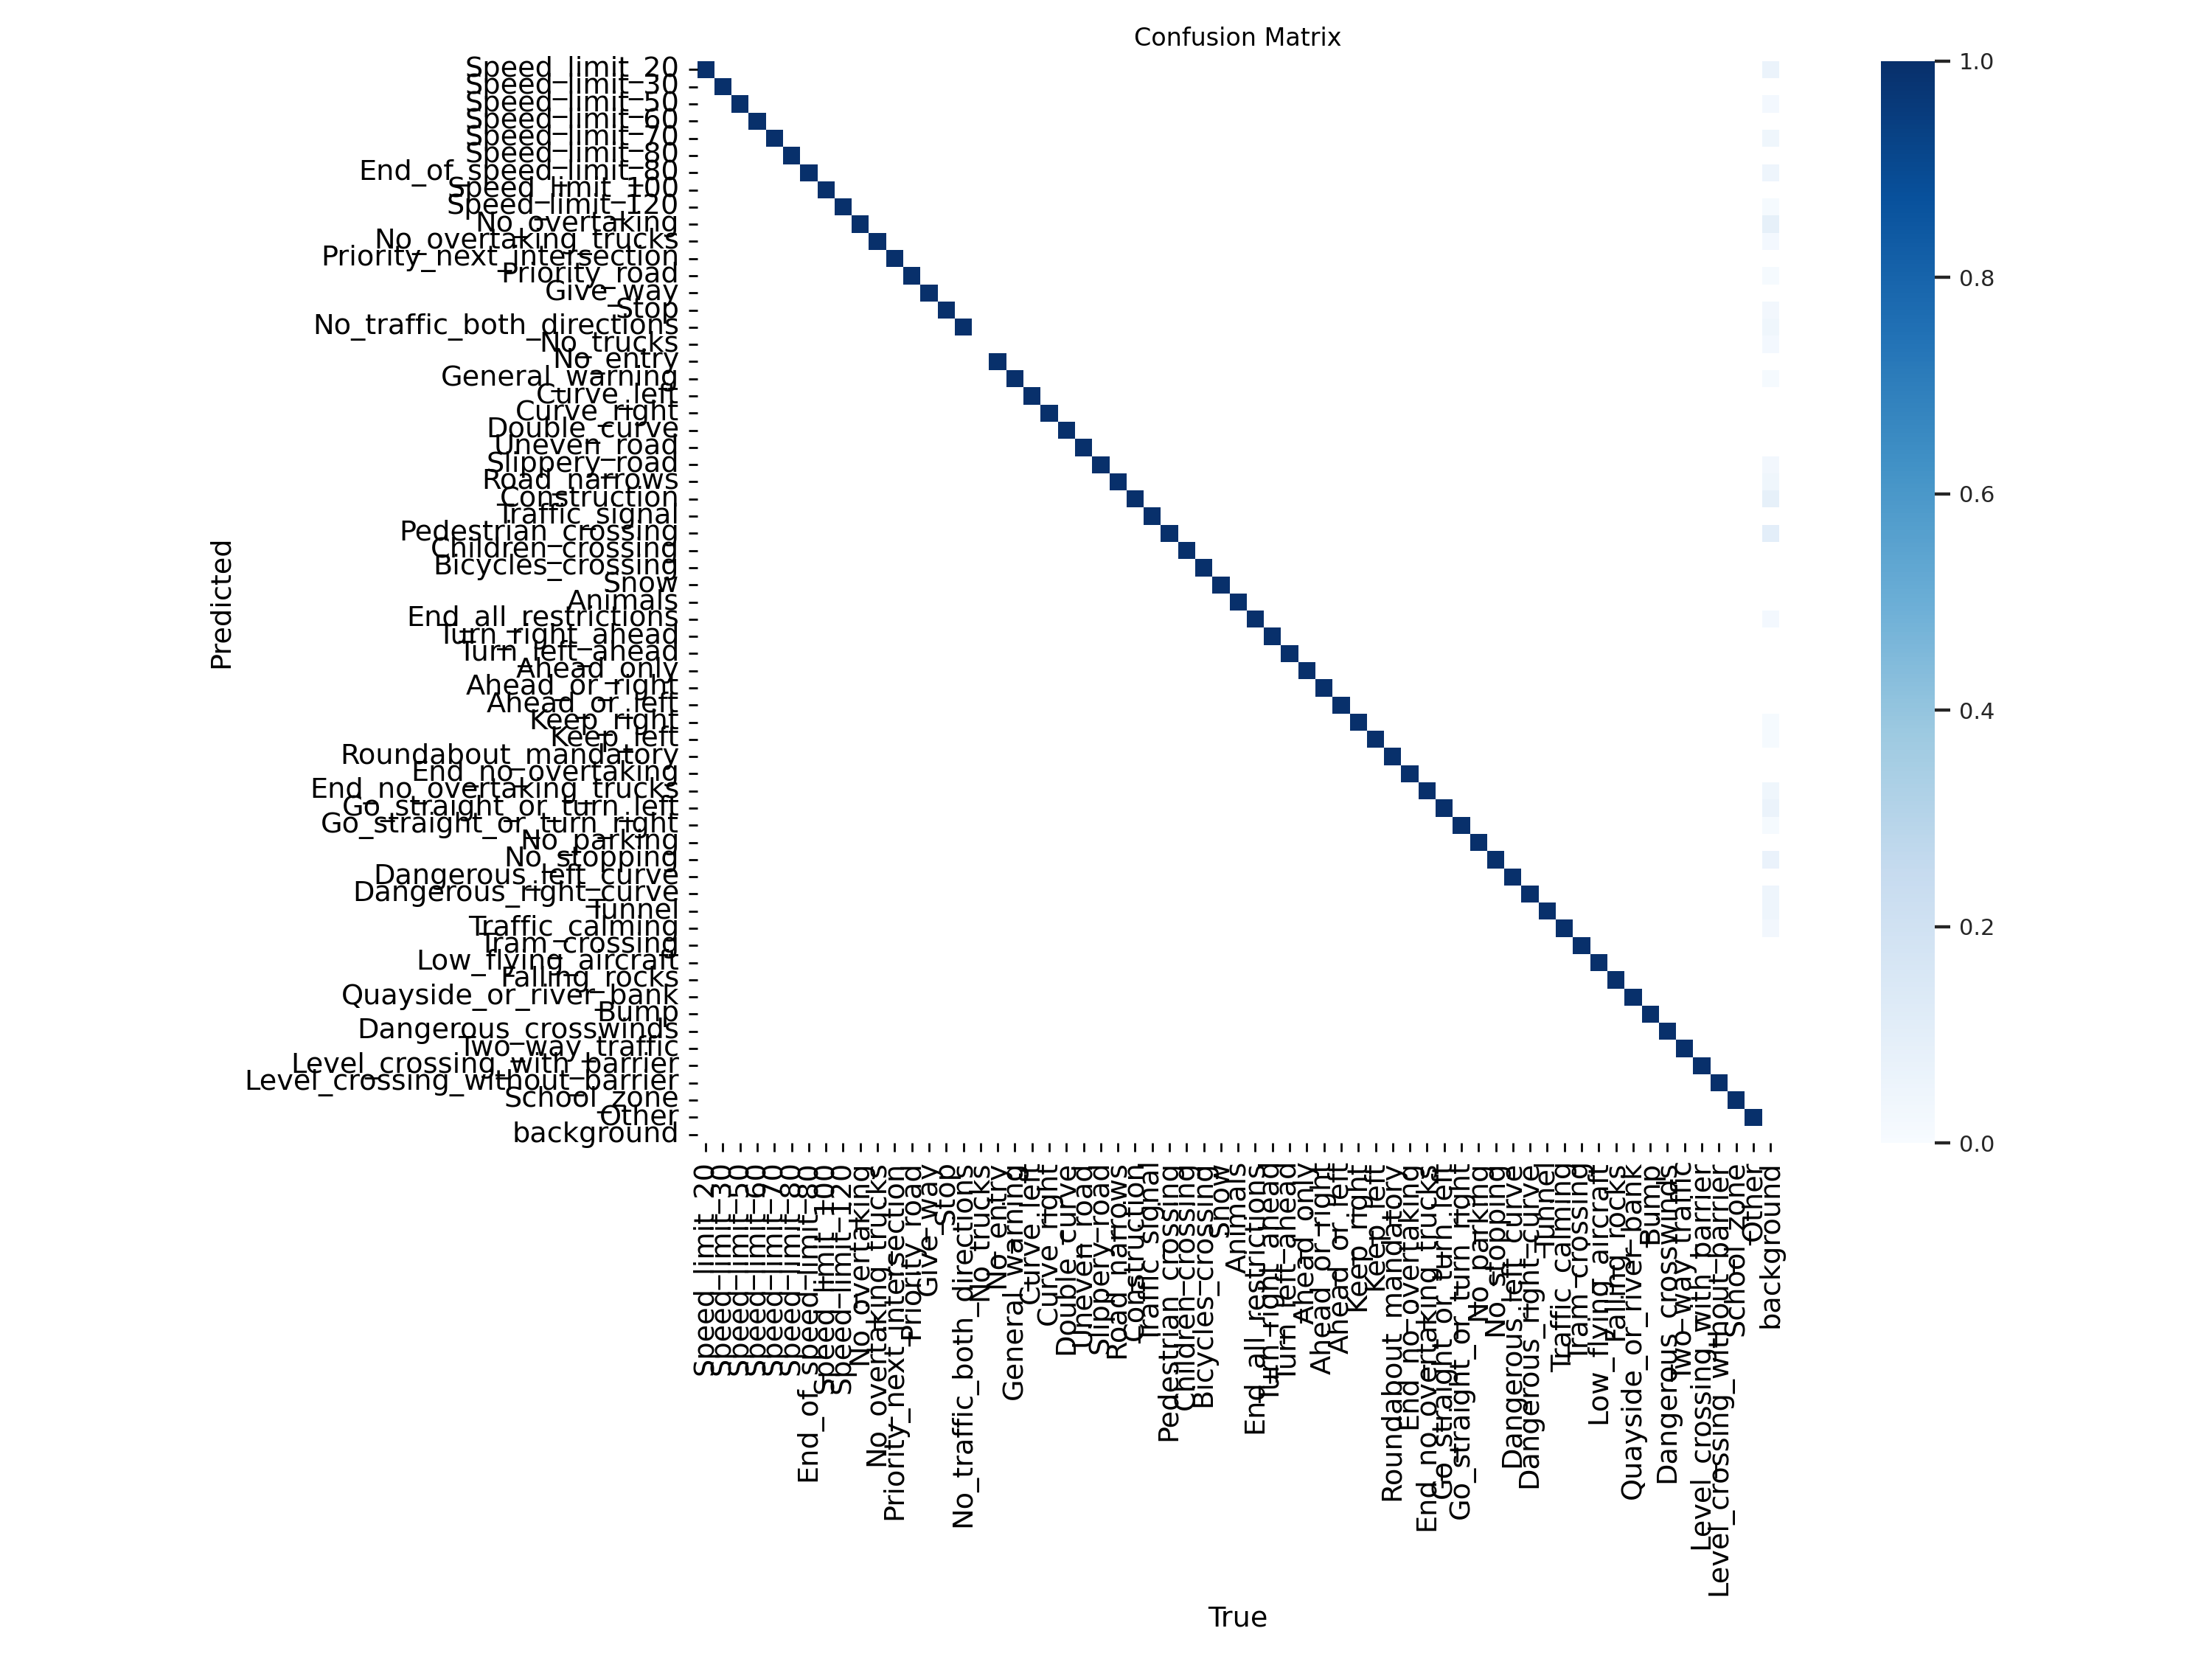

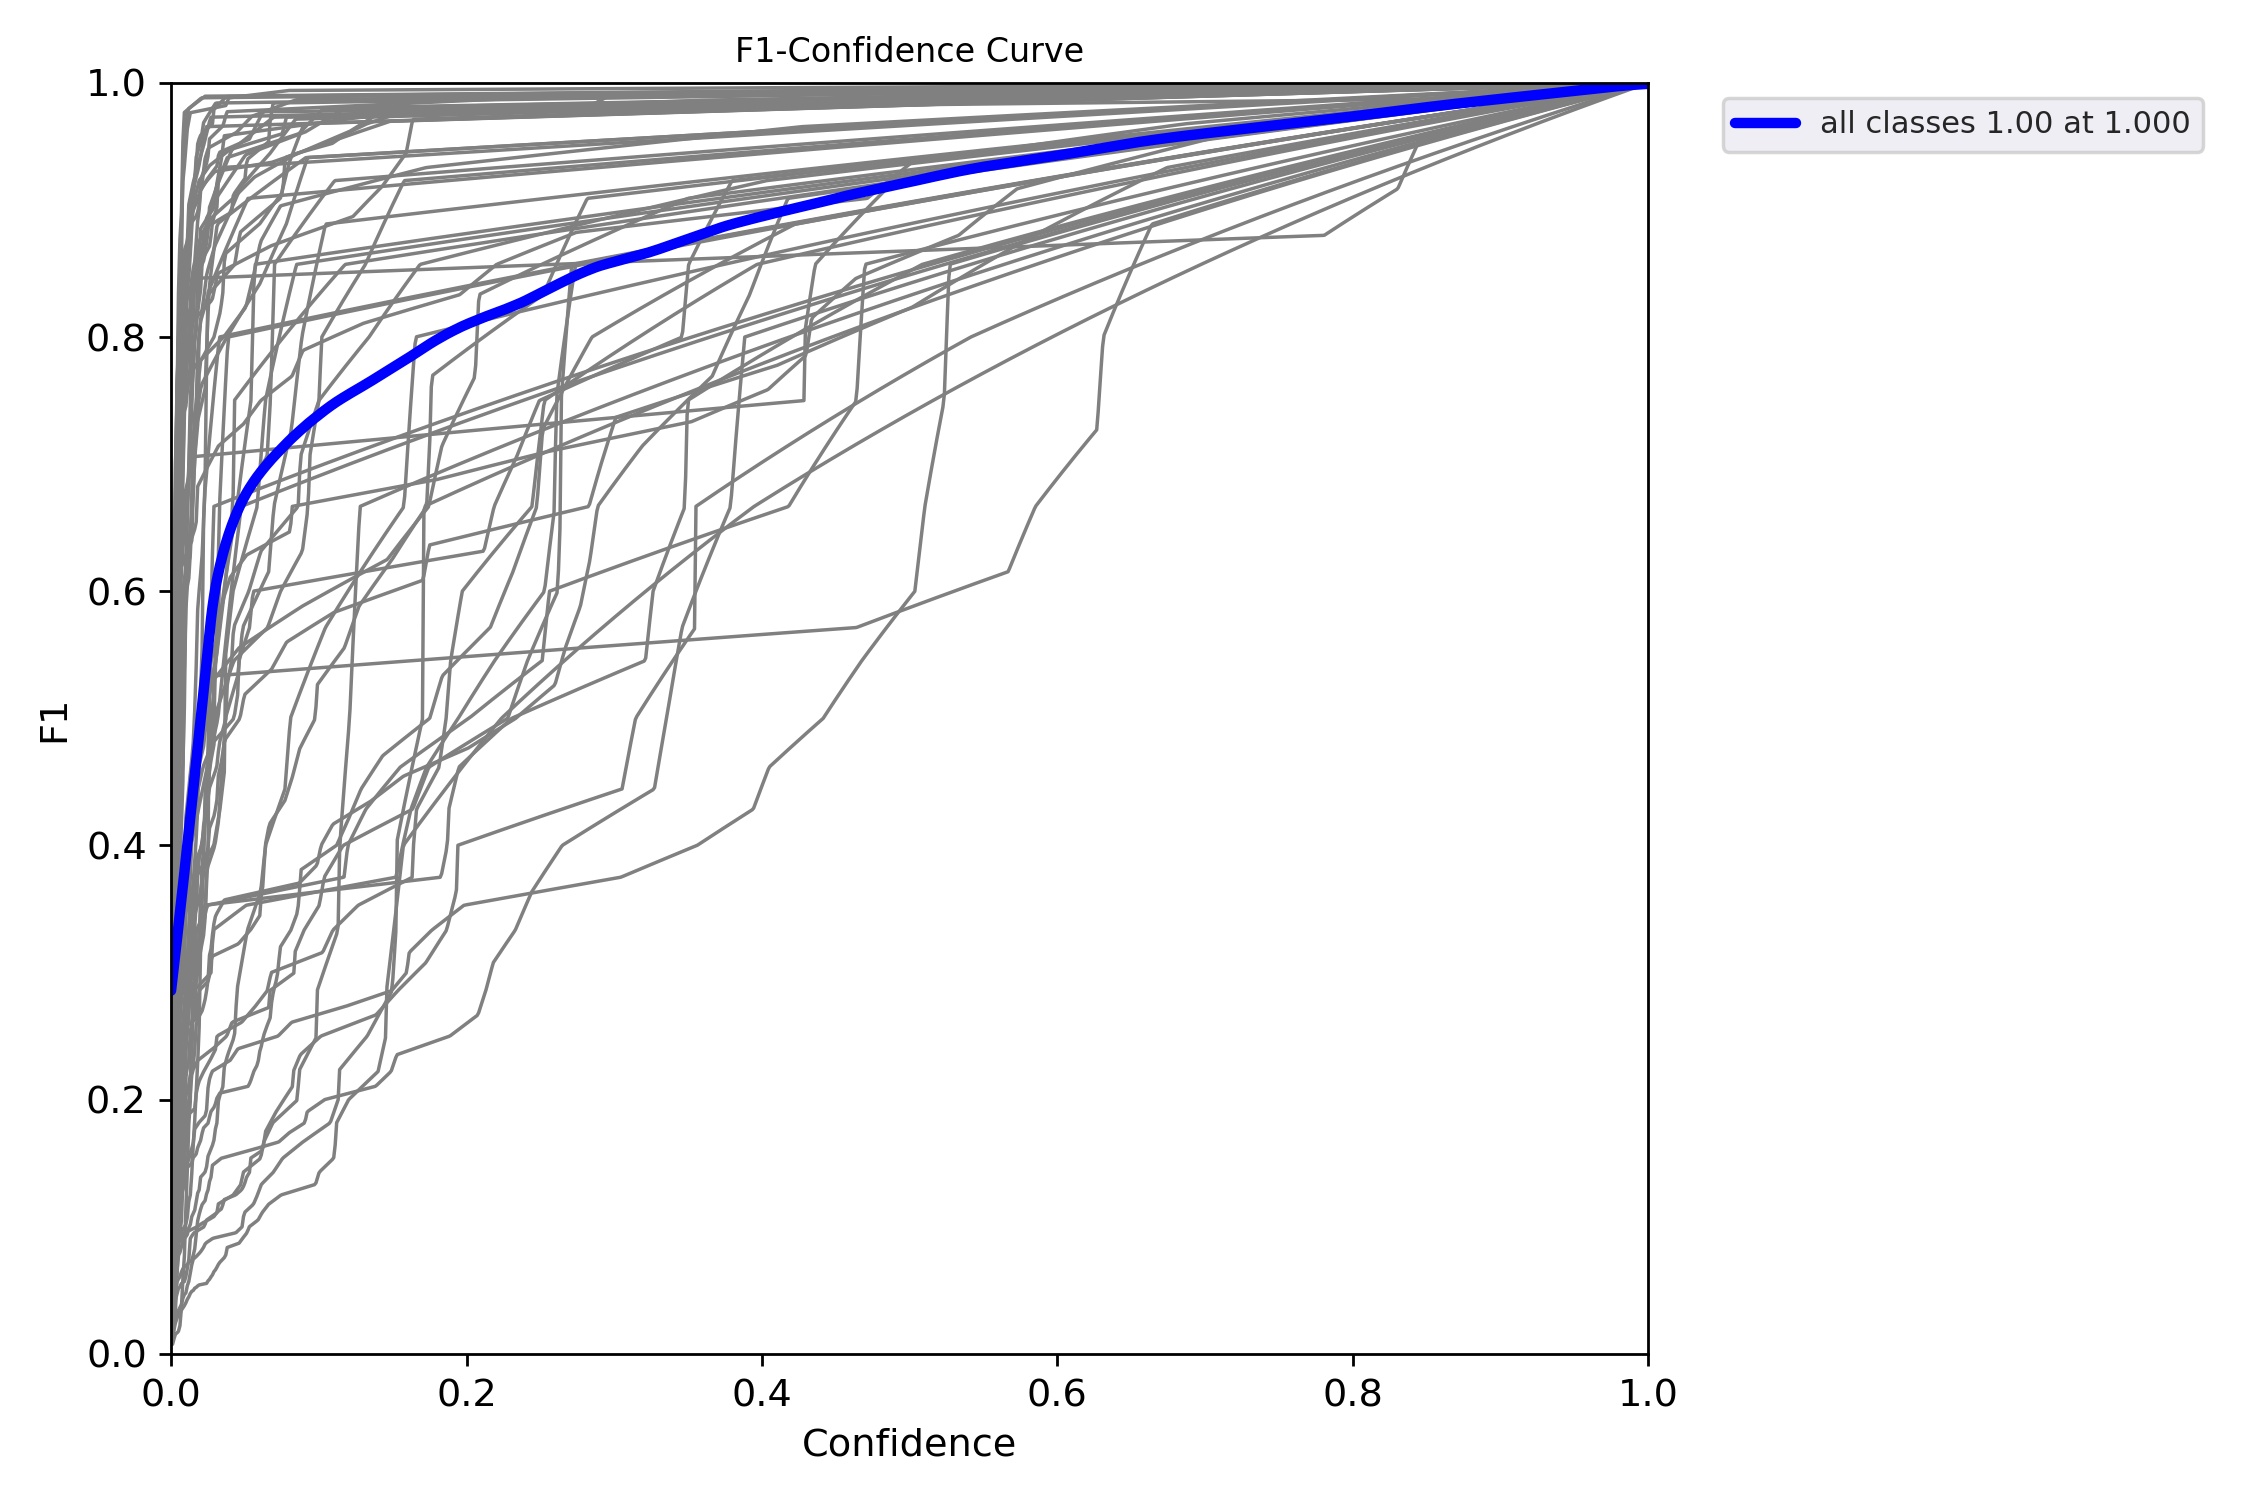

In [51]:
from IPython.display import Image, display
import os

val_output_dir = "yolov5/runs/val/btsd_eval"

files_to_show = ["confusion_matrix.png", "F1_curve.png"]
for fname in files_to_show:
    path = os.path.join(val_output_dir, fname)
    if os.path.exists(path):
        display(Image(filename=path))
    else:
        print(f"{fname} not found.")